# Theoretical signal and noise in ISCAT

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [142]:
# Constants
n_m = 1.33 # Water
n_s = 1.44 # Protein
n_r = 1.52 # Glass
d = 2 * 3.7E-9 # Protein effective scattering radius (65 kDa, albumin)
m = 65E3 # Mass of albumin in Da
wl = 445E-9 # Wavelength
phi = 0. # Phase difference
r_A = 100E-9 # Radius of illumination spot

# 1) Intensity estimation

## 1.1) Reflection amplitude $F_r$

Reflectance for normal incidence (Fresnel eq.) at interface: $R = \left|\frac{n_r-n_m}{n_r+n_m}\right|^2$

Field reflectivity: $F_r = \sqrt{R}$

In [135]:
Fr = (n_r-n_m)/(n_r+n_m)

## 1.2) Scattering amplitude $F_s$

Polarizability: $\alpha = 3V \frac{n_s^2 - n_m^2}{n_s^2 + 2 n_m^2}$

Total cross-section: $\sigma_\text{tot} = \frac{8}{3} \pi^3 \alpha^2 \left(\frac{n_m}{\lambda}\right)^4$

Area of illumination spot: $A = \pi r_A^2$

Scattering factor: $F_s = \sqrt{\frac{\sigma_\text{tot}}{A}} = \sqrt{\frac{2}{3}} \pi^2 \frac{d^3}{r_A} \frac{n_s^2 - n_m^2}{n_s^2 + 2 n_m^2} \left(\frac{n_m}{\lambda}\right)^2$

In [136]:
Fs = lambda d: sqrt(2/3.)*pi**2*d**3/r_A*(n_s**2-n_m**2)/(n_s**2+2*n_m**2)*(n_m/wl)**2

## 1.3) Detected intensity

Illumination intensity ("power") in photons per second: $I_0$

Background intensity (without sample): $I_{\text{bkg}} = I_0 F_r^2$

Sample intensity: $I_{\text{det}} = I_0 \left[ F_r^2 + F_s^2 + 2 F_r F_s \cos(\phi) \right]$

In [137]:
I_det = lambda I0, d: I0*(Fr**2+Fs(d)**2+2*Fr*Fs(d)*cos(phi))
I_bkg = lambda I0: I0 * Fr**2
I_det_approx = lambda I0, d: I0*(Fr**2+2*Fr*Fs(d)*cos(phi))

In [158]:
print "Reflected intensity: %.01e" % (Fr**2)
print "Scattered intensity: %.01e" % (Fs(d)**2)
print "Interference intensity: %.01e" % (2*Fr*Fs(d))

Reflected intensity: 4.4e-03
Scattered intensity: 2.5e-10
Interference intensity: 2.1e-06


In [160]:
print "Normalised reflected intensity: %.01e" % (Fr**2/Fr**2)
print "Normalised scattered intensity: %.01e" % (Fs(d)**2/Fr**2)
print "Normalised interference intensity %.01e" % (2*Fr*Fs(d)/Fr**2)

Normalised reflected intensity: 1.0e+00
Normalised scattered intensity: 5.6e-08
Normalised interference intensity 4.8e-04


## 1.4) iSCAT contrast

$C = \frac{I_\text{det}}{I_\text{bkg}} - 1 = \frac{F_s^2}{F_r^2} + 2 \frac{F_s}{F_r} \cos(\phi) \approx 2 \frac{F_s}{F_r} \cos(\phi)$

In [217]:
C = lambda d: I_det(1., d)/I_bkg(1.) - 1
C_approx = lambda d: I_det_approx(1., d)/I_bkg(1.) - 1

Text(0.5,1,u'Approximation error')

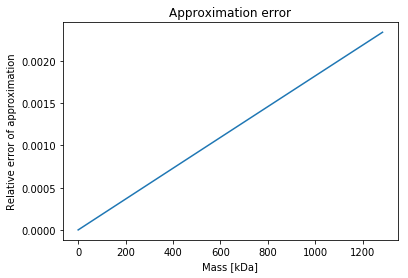

In [161]:
d_arr = linspace(1E-9, 20E-9, 100)
plot(d_arr**3/d**3*m/1E3, (C(d_arr)-C_approx(d_arr))/C(d_arr))
xlabel("Mass [kDa]")
ylabel("Relative error of approximation")
title("Approximation error")

## 2) Error propagation

General: $\sigma_C = \sqrt{ \left(\frac{\partial C}{\partial I_\text{det}}\right)^2 \sigma_{I_\text{det}}^2 + \left(\frac{\partial C}{\partial I_\text{bkg}}\right)^2 \sigma_{I_\text{bkg}}^2 } \approx \sqrt{\frac{1}{I^2} \left( \sigma_{I_\text{det}}^2 + \sigma_{I_\text{bkg}}^2 \right)}$

Poisson noise: $\sigma_C = \sqrt{\frac{1}{I^2} \left( I + I \right)} = \sqrt{\frac{2}{I}}$

Read-out noise and Poisson noise: $\sigma_C = \sqrt{\frac{2}{I} \left( 1 + \frac{\sigma_\text{detector}}{I} \right)}$

## 3) Non-linear detector response

Variation of gain factors / illumination / linearity

Make two examples:

1.) **Ideal**: Ideal response function(input equals output)

2.) **Erf**: Non-ideal response function with decreasing gain and saturation

In [214]:
# Examples for detector responses
from scipy.special import erf
sig = 1.
saturation_level = 1000
fs_response = {
    "ideal" : lambda N: N,
    "erf" : lambda N: erf(N/saturation_level)*saturation_level
}

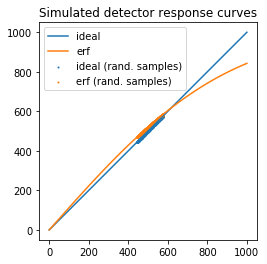

In [252]:
I0_arr = 1E5 + 3E4 * rand(1000)
I_det_arr = asarray([I_det(I0=_I0, d=d) for _I0 in I0_arr])
I_bkg_arr = asarray([I_bkg(I0=_I0) for _I0 in I0_arr])

N_arr = linspace(0, 1E3, 1000)
figure()
title("Simulated detector response curves")
ax = gca()
for tag, f_r in fs_response.items():
    ax.plot(N_arr, f_r(N_arr), label=tag)
    ax.scatter(I_det_arr, f_r(I_det_arr), label=tag + " (rand. samples)", s=1.)
ax.set_aspect(1.)
ax.legend()

Text(0.5,0,u'Interferometric contrast')

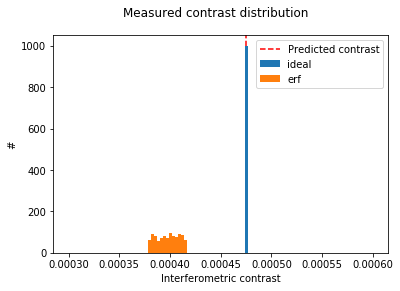

In [272]:
suptitle("Measured contrast distribution")
ax = gca()
ax.axvline(C(d), ls="--", color="red", zorder=1, label="Predicted contrast")
for tag, f_r in fs_response.items():
    C_arr = f_r(I_det_arr)/f_r(I_bkg_arr) - 1
    ax.hist(C_arr, range=(0.3E-3, 0.6E-3), bins=100, label=tag, zorder=10)
ax.legend()
ax.set_ylabel("#")
ax.set_xlabel("Interferometric contrast")